In [1]:
col_names = [
    '2018-12'
]

# years = [
# #     '2009',
# #     '2010',
# #     '2011',
#     '2012',
#     '2013',
#     '2014',
#     '2015',
#     '2016',
#     '2017',
#     '2018',
# ]

In [11]:
import configparser
import warnings
from pymongo import MongoClient

warnings.filterwarnings("ignore", category=DeprecationWarning)

config = configparser.ConfigParser()
config.read('config.ini')
host = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']

client = MongoClient(host, int(port))
db = client['reddit']

# Reddits with 'domestic violence'

In [12]:
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
del reddits
reddits = list(db['2018-12'].find({'$text': {'$search': '"domestic violence"'}}, no_cursor_timeout=True))

In [21]:
len(reddits)

1394

# Day of Week Pattern

In [58]:
import datetime

freqs = [0]*7

for reddit in reddits:
    try:
        ts = reddit['created_utc']
        date = datetime.datetime.utcfromtimestamp(ts)
        day = date.weekday()

        freqs[day] += 1

    except:
        pass

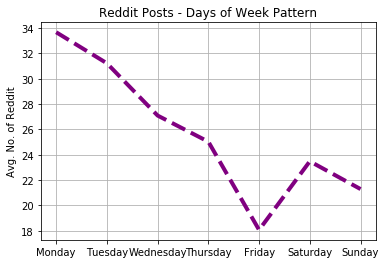

In [59]:
from pylab import *

avg_freqs = [(freq/(31/4)) for freq in freqs]

day = ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')
plot(day, avg_freqs, color='purple', linewidth=4, linestyle='--')
 
ylabel('Avg. No. of Reddit')
title('Reddit Posts - Days of Week Pattern')
grid(True)
show()

# Top Words

In [22]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Stop words
stop = set(stopwords.words('english'))
stop.update([
    'say',
    'would',
    'year',
    'one',
    'go',
    'get',
    'take',
    'also',
    'need',
    'want',
    'make',
    'family',
    'domestic',
    'mr',
    'people',
    'give',
    'could',
    'day',
    'week'
])

# Lemmatizer
lmtz = WordNetLemmatizer()

In [23]:
# Lemmatize words to their base form

def lemmatize(token):
    lemma = lmtz.lemmatize(token, 'v')
    if lemma == token:
        lemma = lmtz.lemmatize(token, 'n')
    return lemma

In [24]:
freqs = {}                           # Word frequency
counter = 0

for reddit in reddits:
    text = ''
    if reddit['title'] != None:
        text += reddit['title']
    if reddit['selftext'] != None:
        text += ' ' + reddit['selftext']

        for token in word_tokenize(text):
            if token.isalpha():
                lemma = lemmatize(token.lower())               # Lemmatize word and update its frequency
                if lemma not in stop:
                    freqs[lemma] = freqs.get(lemma, 0) + 1

    counter += 1
    if counter % 1000 == 0:
        print(counter,'precessed')

1000 precessed


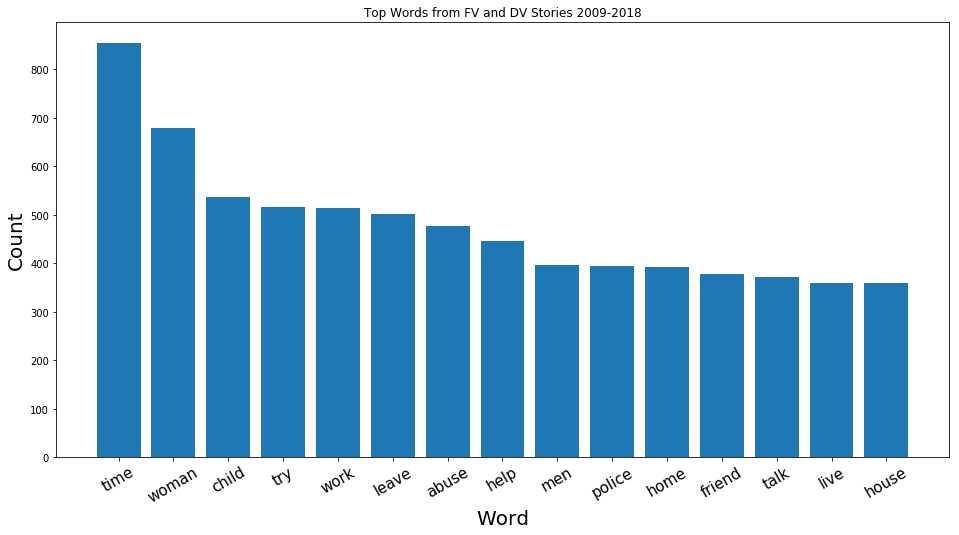

In [33]:
# Bar chart

import numpy as np

x = []          
y = []         
count = 0      

for word in sorted(freqs, key=freqs.get, reverse=True):
    if word not in ['gt','violence','http','amp','like','think','know','even','thing','call','come','feel','back','find','start','really','tell','see','still','never']:
        x.append(word)
        y.append(freqs[word])
        count += 1
        if count == 15:
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Word', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(index, x, fontsize=15, rotation=30)
plt.title('Top Words from FV and DV Stories 2009-2018')
plt.show()

# Top Themes

In [35]:
# Compute frequency for each theme from the database

freq = {}
for reddit in reddits:
    s = reddit['subreddit']
    if s != None:
        for split in s.split(','):
            theme = split.strip()
            freq[theme] = freq.get(theme, 0) + 1

#     counter += 1
#     if counter % 500 == 0:
#         print(counter, 'processed')

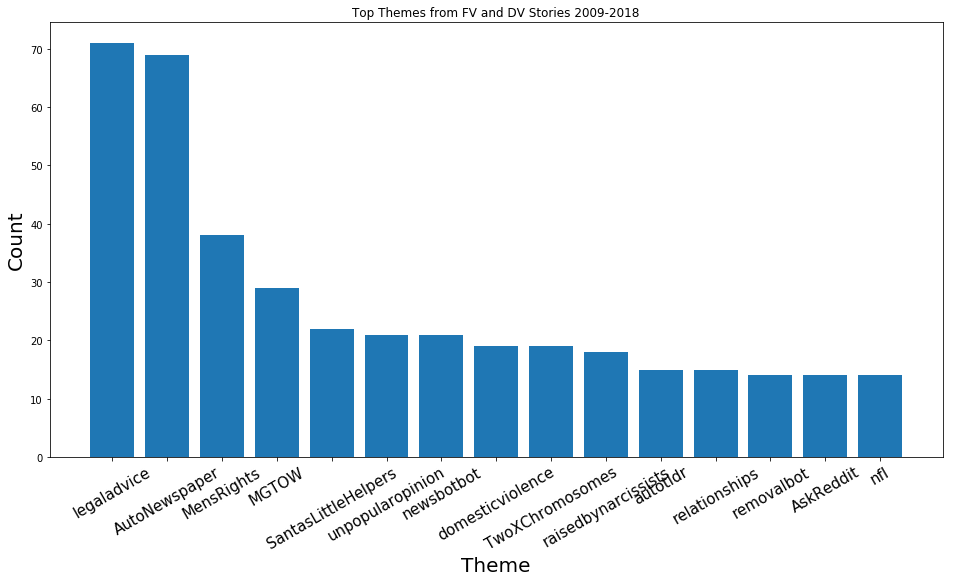

In [38]:
x = []                       # Themes
y = []                       # Story counts
n = 0

for theme in sorted(freq, key=freq.get, reverse=True):
    if theme == 'domestic violence':
        continue
    x.append(theme)
    theme_freq = freq[theme]
    y.append(theme_freq)
    n += 1
    if n == 15:                   # Limit the number of top themes
        break
    
plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Theme', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(index, x, fontsize=15, rotation=30)
plt.title('Top Themes from FV and DV Stories 2009-2018')
plt.show()

In [39]:


labels = []                       
sizes = []                        
n = 0                             

for theme in sorted(freq, key=freq.get, reverse=True):
    if theme == 'domestic violence':
        continue
    labels.append(theme)
    theme_freq = freq[theme]
    sizes.append(theme_freq)
    n += 1
    if n == 10:                   
        break

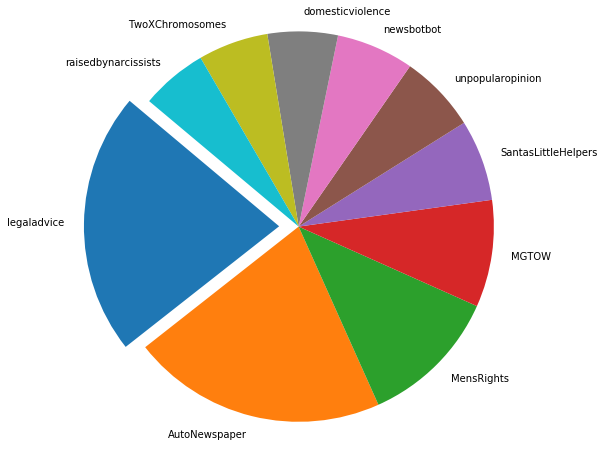

In [40]:
plt.figure(figsize=(8,8))
explode = (0.1,0,0,0,0,0,0,0,0,0)                       # Emphasize the first theme
plt.pie(sizes, labels=labels, startangle=140, explode=explode)  # Display in percentage
 
plt.axis('equal')
plt.show()

# Top Entities (Person, Orgnisation, Location)

In [41]:
# Named entity recognition - Spacy library
# Need to run "python -m spacy download en" & "python -m spacy download en_core_web_sm"

import spacy

nlp = spacy.load('en_core_web_sm')          # English language

In [42]:
person_freqs = {}                    # Named persons - how many percent of stories mentioned them
org_freqs = {}                       # Organisations
loc_freqs = {}                       # Locations

for reddit in reddits:
    text = ''
    if reddit['title'] != None:
        text += reddit['title']
    if reddit['selftext'] != None:
        text += ' '+reddit['selftext']
        
    if text != '':
        counted_ents = set()                                      # Count entities only once for each story
        for ent in nlp(text).ents:                                # Spacy named entities
            name = ent.text

            if name not in counted_ents:
                counted_ents.add(name)

                if ent.label_ == 'PERSON':
                    person_freqs[name] = person_freqs.get(name, 0) + 1
                if ent.label_ == 'ORG':
                    org_freqs[name] = org_freqs.get(name, 0) + 1
                if ent.label_ == 'GPE':                                          # Countries/states/...
                    loc_freqs[name] = loc_freqs.get(name, 0) + 1
                    

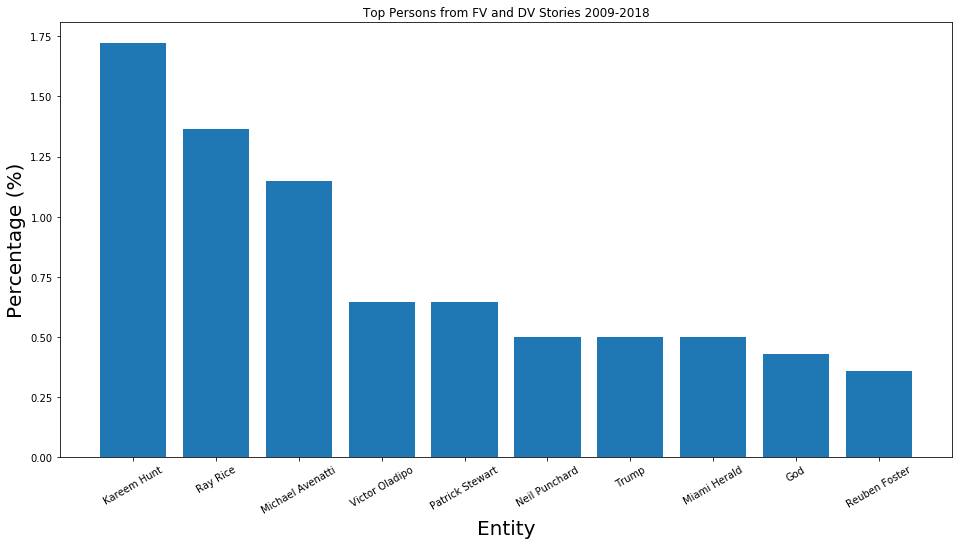

In [51]:
import numpy as np
# We combine all the stories under Luke Batty, Rosie Batty and Batty into Batty bucket

# Top persons

freqs = person_freqs

# Adjust for same entities
freqs['Kareem Hunt'] += freqs['Hunt']
freqs['Hunt'] = 0
 
x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
    if ent.strip() != '' and 'Christmas' not in ent and 'Edit' not in ent and 'football' not in ent and 'Bonus' not in ent and 'Oladipo G' not in ent and 'Gunowner' not in ent:
        x.append(ent.strip())
        total = 1394        
        y.append(freqs[ent]/total*100)                                       
        count += 1
        if count == 10:                                                      
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Persons from FV and DV Stories 2009-2018')
plt.show()

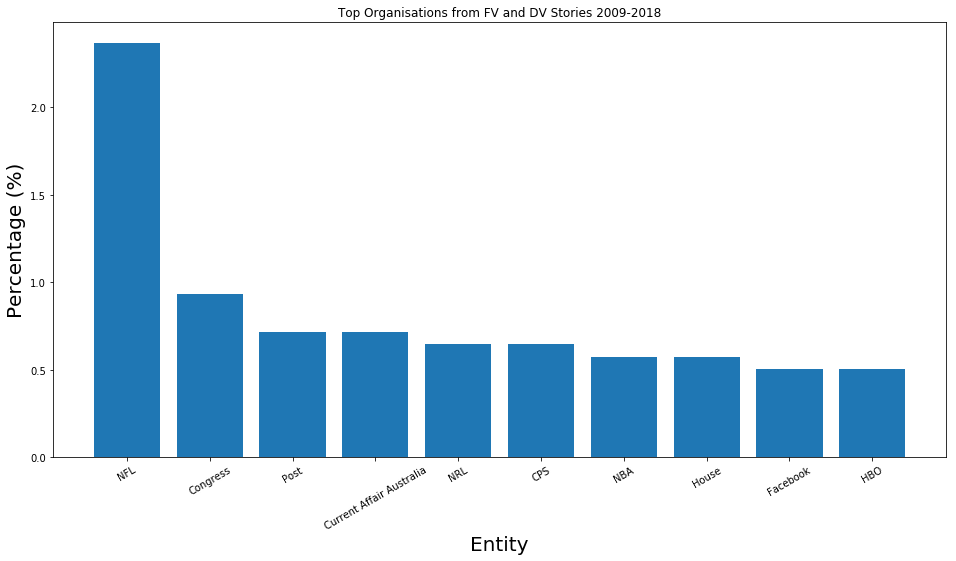

In [55]:
# Top orgs

freqs = org_freqs

x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
:
        x.append(ent.strip())
        total = 1394        
        y.append(freqs[ent]/total*100)                                       
        count += 1
        if count == 10:                                                      
            break
            
plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Organisations from FV and DV Stories 2009-2018')
plt.show()

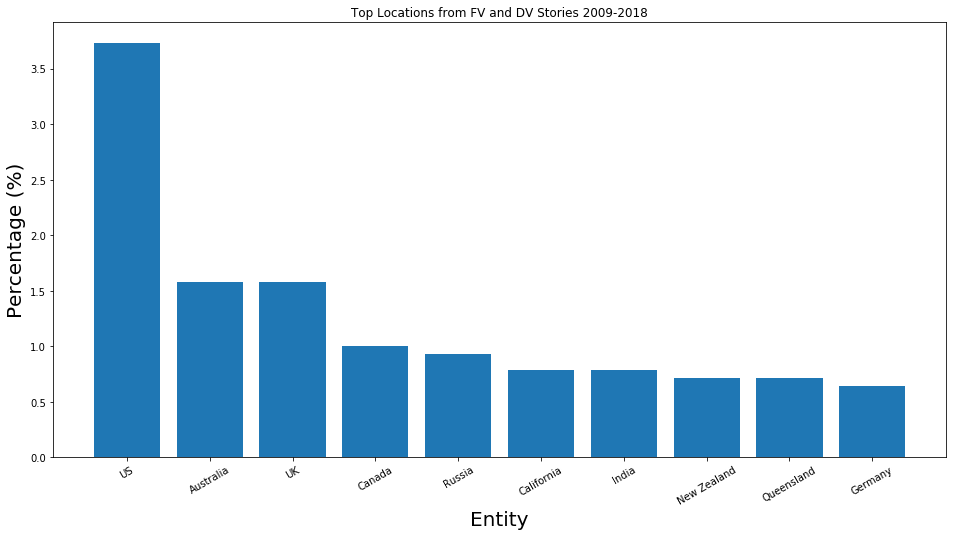

In [57]:
# Top locations

freqs = loc_freqs

freqs['US'] += freqs['U.S.']
freqs['U.S.'] = 0

x = []          # X axis - entities
y = []          # Y axis - percentage of stories with the entity
count = 0       # Numer of top entities to show

for ent in sorted(freqs, key=freqs.get, reverse=True):
    
    # Error values
    if ent.strip() not in ['','Santa','/r']:
        x.append(ent.strip())
        total = 1394        
        y.append(freqs[ent]/total*100)                                       
        count += 1
        if count == 10:                                                      
            break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Entity', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=20)
plt.xticks(index, x, fontsize=10, rotation=30)
plt.title('Top Locations from FV and DV Stories 2009-2018')
plt.show()

# Help Seeking Info Analysis (Data set too small)

In [ ]:
help_lines = {
    'Lifeline': '131114', 
    'Mensline': '1300789978',
    'Kids Helpline': '1800551800',
    '1800 RESPECT': '1800737732',
    'DV Connect Mensline': '1800600636',
    'DV Connect Womensline': '1800811811',
    'Triple Zero': '000',
    'National Disability Abuse and Neglect Hotline': '1800880052',
    '24-hour emergency line 2': '64581828',
    '24-hour emergency line': '1800199888',
    'Domestic Violence Line': '1800656463',
    'Beyond Blue': '1300224636',
    'Crime Stoppers Australia': '1800333000',
    "NTV Men's Referral Service": '1300766491',
    'NSW Police Assistance Line': '131444'
}

In [ ]:
total = db['fv'].find({}).count() + db['dv-fv'].find({}).count()
total

In [ ]:
num_help_info = 0
help_line_freqs = {}
counter = 0

for col_name in col_names:
    col = db[col_name]
    
    for story in col.find({}, no_cursor_timeout=True):
        text = story['text'].replace(' ', '').replace('-', '').lower().strip()
        
        for name, number in help_lines.items():
            name_lower = name.replace(' ', '').replace('-', '').lower()
            if name_lower in text or number in text:
                num_help_info += 1
                help_line_freqs[name] = help_line_freqs.get(name, 0) + 1
                
        counter += 1
        if counter % 100 == 0:
            print(counter)

In [ ]:
sizes = [num_help_info, total-num_help_info]
labels = ['With Help Info', 'Without Help Info']

plt.figure(figsize=(8,8))
explode = (0,0)
plt.pie(sizes, autopct='%1.1f%%', labels=labels, explode=explode) 
 
plt.axis('equal')
plt.show()

In [ ]:
labels = []                       
sizes = []                        
n = 0                             

for line in sorted(help_line_freqs, key=help_line_freqs.get, reverse=True):
    labels.append(line)
    sizes.append(help_line_freqs[line])
    n += 1
    if n == 100:                   
        break
        
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels)  # Display in percentage
 
plt.axis('equal')
plt.show()

#### extra

In [60]:
numbers = set()

for reddit in reddits:
    text = ''
    if reddit['title'] != None:
        text += reddit['title']
    if reddit['selftext'] != None:
        text += ' '+reddit['selftext']
    text += '*'

    i = 0
    while i < len(text)-5:
        if not text[i].isdigit():
            i += 1
        else:
            j = i+1
            while j < len(text) and (text[j].isdigit() or text[j] == ' '):
                j += 1
            num = text[i: j].replace(' ','').strip()
            if len(num) > 5:
                if num not in numbers:
                    numbers.add(num)
            i = j+1

In [61]:
help_line_freqs = {}

for reddit in reddits:
    text = ''
    if reddit['title'] != None:
        text += reddit['title']
    if reddit['selftext'] != None:
        text += ' '+reddit['selftext']
    text = text.replace(' ', '').replace('-', '').strip()

    for number in numbers:
        if len(number) >= 6 and number in text:
            help_line_freqs[number] = help_line_freqs.get(number, 0) + 1

In [62]:
for key in sorted(help_line_freqs, key=help_line_freqs.get, reverse=True):
    print(key, ':', help_line_freqs[key])

131114 : 4
116123 : 4
1800551800 : 3
08088002222 : 3
20181203 : 3
0800585858 : 3
775774 : 3
1300224636 : 3
03333233880 : 3
08453906232 : 3
08088025544 : 3
08000684141 : 3
1854883 : 2
0800543354 : 2
010195202 : 2
800860022 : 2
81533300 : 2
3726558088 : 2
4833888 : 2
0145394000 : 2
0078202577577 : 2
5270000 : 2
70201201 : 2
20181205 : 2
120318 : 2
1300789978 : 2
08454560455 : 2
08088004444 : 2
02079316480 : 2
02089048193 : 2
03001000212 : 2
03003300700 : 2
08088084000 : 2
08452967877 : 2
08453000336 : 2
03001110101 : 2
08088080545 : 2
07786209697 : 2
08451228660 : 2
08088002073 : 2
08088082008 : 2
08445616855 : 2
02085549004 : 2
0800776600 : 2
08082000247 : 2
08088029999 : 2
08456341414 : 2
02089086715 : 2
08457660163 : 2
03009991212 : 2
08444775774 : 2
07393561735 : 2
08451228622 : 2
08457678000 : 2
08088084994 : 2
08451228642 : 2
08451221201 : 2
08006226000 : 2
08006529249 : 2
08700053273 : 2
08444779400 : 2
02078403188 : 2
08457697555 : 2
03003300630 : 2
08451232320 : 2
02073860868 : 